**Who owns Seattle Airbnbs?**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
seattle_reviews = pd.read_csv('seattle_reviews.csv')
seattle_listings = pd.read_csv('seattle_listings.csv')
seattle_calendar = pd.read_csv('seattle_calendar.csv')

In [3]:
print(seattle_listings.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [4]:
# Make sure that values in 'id' column are unique... (i.e. no duplicates)

len(seattle_listings['id'].unique()) == seattle_listings.shape[0]


True

In [5]:
# Get hosts with more than 10 properties and what those properties are

investor_count = (seattle_listings[['host_id','host_name','host_url','host_listings_count']][seattle_listings['host_listings_count']>10]
                          .drop_duplicates('host_id').sort_values(by='host_listings_count', ascending=False))

In [6]:
# Rename the hosts using host_id (taken manually from host_url column)

investor_dictionary = {8534462:'Barsala',
                      4962900:'Stay Alfred',
                      1243056:'Grokhome',
                      74305:'Seattle Oasis',
                      658155:'Kenny Properties LLC',
                      31148752:'TurnKey',
                      66145:'The Dexter Experience',
                      30283594:'Global Luxury Suites',
                      1478274:'LiveLikeItsYours'}

# Change the names of hosts with IDs in the investor_dictionary, leave untouched those that aren't 
seattle_listings['host_name'] = seattle_listings['host_id'].map(investor_dictionary).fillna(seattle_listings['host_name'])

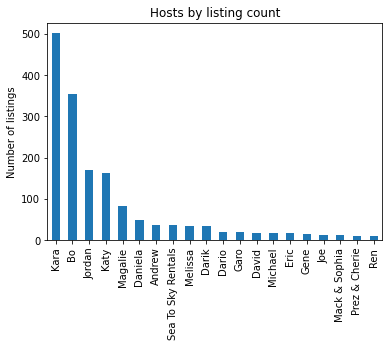

In [7]:
# Plot hosts by host_listing_count

investor_count[['host_name', 'host_listings_count']].plot(kind='bar', legend=None);
x = investor_count['host_name']
x_pos = [i for i, _ in enumerate(x)]
plt.xticks(x_pos, x);
plt.xlabel('');
plt.ylabel('Number of listings');
plt.title('Hosts by listing count');

In [8]:
# Get investor listing_ids

investor_df = (seattle_listings[['host_id','host_name','host_url','id','host_listings_count']][seattle_listings['host_listings_count']>10]
                       .rename({'id':'listing_id'}, axis=1).sort_values('host_id'))

investor_calendar = pd.merge(seattle_calendar[seattle_calendar['listing_id'].isin(investor_df['listing_id'])],
                              investor_df, how='left', left_on='listing_id', right_on='listing_id')

# How many days of data are available for each listing?

# How many investor listings are reflected in seattle_calendar? Can we confirm that there is a year's worth of data for all of them?

print('There are {} investor-hosted listings in seattle_calendar.'.format(len(investor_calendar['listing_id'].unique())))

try:
    assert(investor_calendar[['host_name','listing_id', 'date', 'available']].groupby('listing_id').count()['date'].unique()[0]==365)
except:
    print('Unbalanced data! Not all listings have 365 rows of availability... available')

investor_calendar_count = (pd.DataFrame(investor_calendar['host_name'].value_counts()/365).reset_index()
                           .rename({'index':'host_name', 'host_name':'count'},axis=1))

# Merge dataframes to calculate R-index

merged_investor_calendar_count = pd.merge(investor_calendar_count, investor_df[['host_id','host_name','host_listings_count']], on='host_name', how='inner').drop_duplicates('host_name')
merged_investor_calendar_count['r-index'] = merged_investor_calendar_count['count']/merged_investor_calendar_count['host_listings_count']

r_index_df = (merged_investor_calendar_count[['host_id', 'host_name', 'r-index']].sort_values(by='r-index', ascending=False).reset_index(drop=True))

print(r_index_df)

There are 352 investor-hosted listings in seattle_calendar.
     host_id              host_name   r-index
0    1623580          Mack & Sophia  1.000000
1     862329          Prez & Cherie  1.000000
2    1243056               Grokhome  1.000000
3     430709     Sea To Sky Rentals  1.000000
4    3074414                Melissa  1.000000
5   26967583                  Dario  1.000000
6    7354306                Michael  1.000000
7    2911360                    Ren  1.000000
8      74305          Seattle Oasis  0.970588
9    8534462                Barsala  0.958333
10  42537846                   Eric  0.941176
11    658155   Kenny Properties LLC  0.923077
12   4962900            Stay Alfred  0.230769
13  24689607                   Garo  0.210526
14     66145  The Dexter Experience  0.200000
15   1478274       LiveLikeItsYours  0.055556
16  31148752                TurnKey  0.028249
17    661691                   Katy  0.024540
18    103427                Magalie  0.023810
19  30283594   Globa

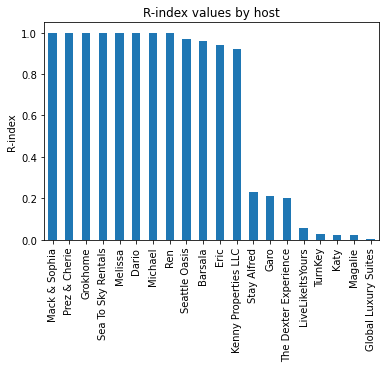

In [9]:
x = r_index_df['host_name']
x_pos = [i for i, _ in enumerate(x)]
r_index_df[['host_name', 'r-index']].plot(kind='bar', legend=None);
plt.xticks(x_pos, x);
plt.xlabel('');
plt.ylabel('R-index');
plt.title('R-index values by host');

In [10]:
# List object containing the listings of the new investor list, with r-index values greater than 0.90
new_investor_list = investor_df[investor_df['host_id'].isin(r_index_df['host_id'][r_index_df['r-index']>0.90])]

# Get listings and calendar datasets for this new set of investors
investor_calendar = pd.merge(seattle_calendar[seattle_calendar['listing_id'].isin(new_investor_list['listing_id'])],
                              investor_df, how='left', left_on='listing_id', right_on='listing_id')

#DataFrame containing the full characteristics
investor_listings = seattle_listings[seattle_listings['host_id'].isin(new_investor_list['host_id'])]

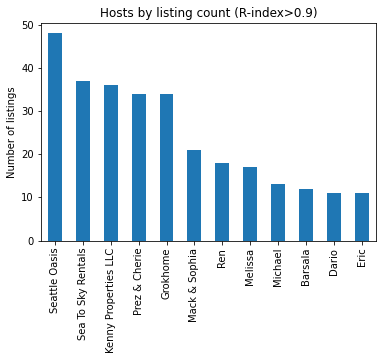

In [11]:
# Plot new host set by host_listing_count

(new_investor_list[['host_name', 'host_listings_count']]).drop_duplicates('host_name').sort_values(by='host_listings_count', ascending=False).plot(kind='bar', legend=None);
x = new_investor_list['host_name'].unique()
x_pos = [i for i, _ in enumerate(x)]
plt.xticks(x_pos, x);
plt.xlabel('');
plt.ylabel('Number of listings');
plt.title('Hosts by listing count (R-index>0.9)');

<h1>Occupancy</h1>

**Calculating occupancy rates using the availability calendar**

In [12]:
# The availability_30 feature gives us a snapshot into a unit's availability but if we really want to dig deep 
# we should look at the seattle_calendar (investor_calendar) dataset

(seattle_listings[['host_id', 'availability_30']][seattle_listings['host_id'].isin(new_investor_list['host_id'])].groupby('host_id').mean()\
 .sort_values(by='availability_30', ascending=False))

,availability_30
host_id,
862329,30.000000
1243056,26.621622
3074414,25.852941
430709,22.055556
74305,21.454545
8534462,20.673913
658155,20.166667
2911360,19.090909
26967583,18.761905


In [13]:
# First, create separate DataFrame to collect these values
listings_per_host = pd.DataFrame(investor_calendar['host_name'].unique(), columns=['host_name'])
listings_per_host['calculated_host_listings'] = listings_per_host['host_name'].apply(lambda x: investor_calendar[investor_calendar['host_name'] == x].shape[0]/365)

# Merge with investor calendar
investor_calendar = pd.merge(investor_calendar, listings_per_host, on='host_name')



In [14]:
# Need the number of listings each host has in investor_calendar (which may != host_listings_count)

num_not_eq = sum(investor_calendar['host_listings_count'] != investor_calendar['calculated_host_listings'])
print("There are {} (out of {}) rows where calculated_host_listings is not equal to host_listings_count".format(num_not_eq, investor_calendar.shape[0]))


There are 39055 (out of 104755) rows where calculated_host_listings is not equal to host_listings_count


**Creating investor availability dataset by host**

In [16]:
# Create DataFrame to show each listing by date and whether it was available or not
# Rewriting code

investor_availability = (investor_calendar.groupby(['host_name', 'available'], as_index=False).count()[['host_name','available','listing_id']]
                            .rename({'listing_id':'count'}, axis=1))

# Available = 'f' means that the listing is occupied
#investor_availability_ts =  investor_availability_ts[investor_availability_ts['available']=='f']

# Divide # available per day by total # of unique listings (287) to produce the daily occupancy rate
#investor_availability_ts['occupancy_rate'] = investor_availability_ts['count']/287

# Investor occupancy rate by host
investor_or_host = investor_availability[investor_availability['available']=='f']

listings_per_host['calculated_host_listings'] = listings_per_host['calculated_host_listings']*365

investor_or_host = pd.merge(investor_or_host, listings_per_host, on='host_name')

investor_or_host['occupancy_rate'] = investor_or_host['count']/investor_or_host['calculated_host_listings']

investor_availability_mean_val = investor_or_host['occupancy_rate'].mean()

# Note: occupancy rates turn out to be different depending on how you calculate them. 

0.22888380923844956

In [17]:
non_investor_calendar = seattle_calendar[~(seattle_calendar['listing_id'].isin(investor_listings['id']))]

# Need total number of non-investor listings:
# We don't care so much about who owns them so we'll calculate mean occupancy rate by date instead

# Creating non-investor listing time series

num_l = len(non_investor_calendar['listing_id'].unique())

non_investor_availability = (non_investor_calendar.groupby(['date', 'available'], as_index=False).count()[['date', 'available', 'listing_id']])
non_investor_availability = non_investor_availability[non_investor_availability['available']=='f']

non_investor_availability['occupancy_rate'] = non_investor_availability['listing_id']/num_l

non_investor_availability_mean_val = non_investor_availability['occupancy_rate'].mean()

print('The mean occupancy rate in 2016 for investor-hosted listings was {:.2f}% (when calculated by host)'.format(investor_availability_mean_val))
print('The mean occupancy rate in 2016 for non-investor-hosted listings was {:.2f}% (when calculated as a time series)'.format(non_investor_availability_mean_val))

The mean occupancy rate in 2016 for investor-hosted listings was 0.23% (when calculated by host)
The mean occupancy rate in 2016 for non-investor-hosted listings was 0.34% (when calculated as a time series)


**Creating investor availability dataset by date**

In [18]:
# Create DataFrame to show each listing by date and whether it was available or not

investor_availability_ts = (investor_calendar.groupby(['date', 'available'], as_index=False).count()[['date','available','listing_id']]
                            .rename({'listing_id':'count'}, axis=1))

# Available = 'f' means that the listing is occupied
investor_availability_ts =  investor_availability_ts[investor_availability_ts['available']=='f']

# Divide # available per day by total # of unique listings (287) to produce the daily occupancy rate
investor_availability_ts['occupancy_rate'] = investor_availability_ts['count']/287

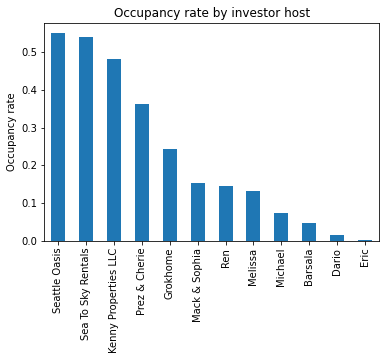

In [52]:
investor_or_host[['host_name', 'occupancy_rate']].sort_values(by='occupancy_rate', ascending=False).plot(kind='bar', legend=None)
x = new_investor_list['host_name'].unique()
x_pos = [i for i, _ in enumerate(x)]
plt.xticks(x_pos, x);
plt.xlabel('');
plt.ylabel('Occupancy rate');
plt.title('Occupancy rate by investor host');

In [46]:
investor_or_host

,host_name,available,count,calculated_host_listings,occupancy_rate
0,Barsala,f,8116,16790.0,0.483383
1,Dario,f,4218,7665.0,0.550294
2,Eric,f,888,5840.0,0.152055
3,Grokhome,f,215,13505.0,0.015920
4,Kenny Properties LLC,f,1588,4380.0,0.362557
5,Mack & Sophia,f,1065,4380.0,0.243151
6,Melissa,f,916,12410.0,0.073811
7,Michael,f,315,6570.0,0.047945
8,Prez & Cherie,f,2,4015.0,0.000498
9,Ren,f,524,4015.0,0.130511


**Plotting investor vs. non-investor owned listing occupancy rates**

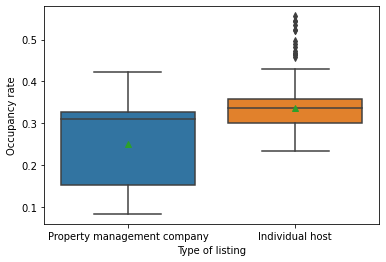

In [53]:
import seaborn as sns

boxplot_df = pd.concat([investor_availability_ts['occupancy_rate'], non_investor_availability['occupancy_rate']], axis=1)
boxplot_df.columns = ['Property management company', 'Individual host']

bp = sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_df));
bp.set(xlabel="Type of listing", ylabel="Occupancy rate");


**Testing for difference in mean occupancy rates between investor and non-investor groups**

In [54]:
# Because we are only dealing with two groups, we can use a t-test.
# We will use the independent variant of the t-test since our a priori assumption is that the occupancy rates of the 
# investor and non-investor groups are independent

# First, import the requisite library:

from scipy.stats import ttest_ind

# Set parameter equal_var=False because we cannot say whether the variances of the populations are equal to each other
t_test_result = ttest_ind(investor_availability_ts['occupancy_rate'], non_investor_availability['occupancy_rate'], equal_var=False)

t_stat = t_test_result[0]
p_val = t_test_result[1]

(print('''The t-value is {:.3f} and the associated p-value is {}. 
We can conclude that there is a statistically significant difference between the occupancy rates of investor-hosted versus 
non-investor-hosted Airbnb listings.'''.format(t_stat, p_val)))

The t-value is -15.490 and the associated p-value is 1.9505163277129135e-45. 
We can conclude that there is a statistically significant difference between the occupancy rates of investor-hosted versus 
non-investor-hosted Airbnb listings.
